<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-MODULE3-MLP-LARGE%20-%20INITIAL%20PRETRAINING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded data shapes - X: (482042, 1200), Y: (482042,)


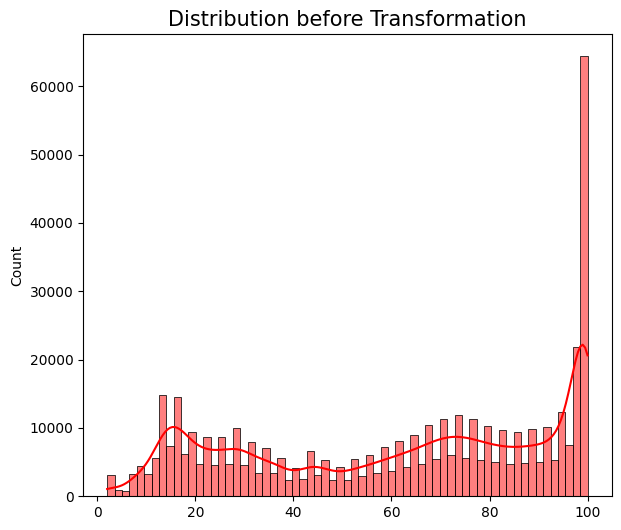

Train/Test split - X_train: (433837, 1200), X_test: (48205, 1200)
Train/Test split - y_train: (433837,), y_test: (48205,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


No existing checkpoint found. Training from scratch...
6101/6101 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.2674 - mae: 0.5733 - val_loss: 0.2209 - val_mae: 0.4926
Epoch 1/200
6101/6101 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.2050 - mae: 0.4811 - val_loss: 0.1814 - val_mae: 0.4524
Epoch 2/200
6101/6101 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1917 - mae: 0.4592 - val_loss: 0.1705 - val_mae: 0.4234
Epoch 3/200
6101/6101 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1829 - mae: 0.4438 - val_loss: 0.1690 - val_mae: 0.4144
Epoch 4/200
6101/6101 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1746 - mae: 0.4296 - val_loss: 0.1602 - val_mae: 0.4153
Epoch 5/200
6101/6101 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1685 - mae: 0.4191 - val_loss: 0.1551 - val_mae: 0.3922
Epoch 6/200
6101/6101 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1627 - mae: 0.4072 - val_loss: 0.1536 - val_mae: 0.3911
Epoch 7/200
6101/6101 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1598 - mae: 0.4017 - val_loss: 0.1477

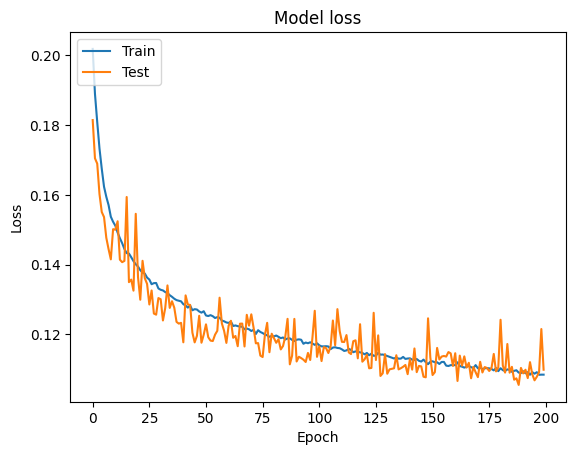

13558/13558 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
Training r2 score is == 0.7570586397134098


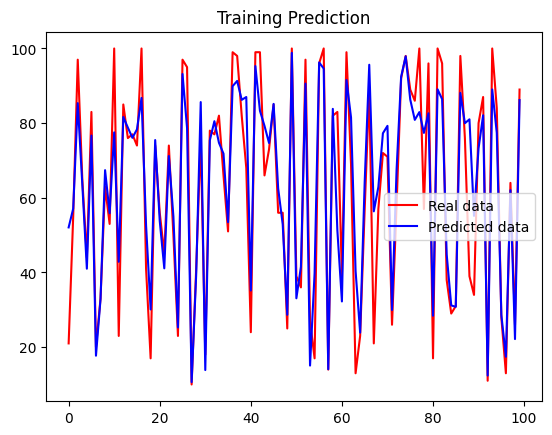

1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test r2 score is == 0.7366615209001872


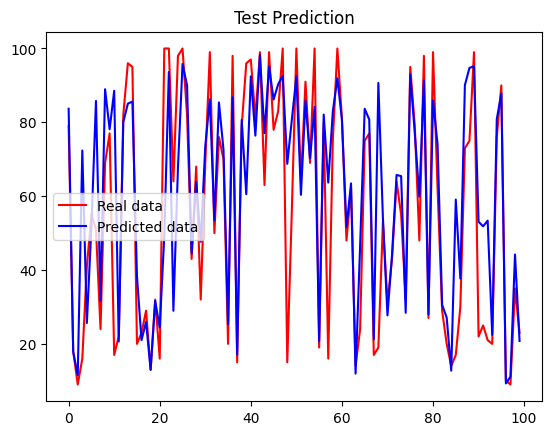

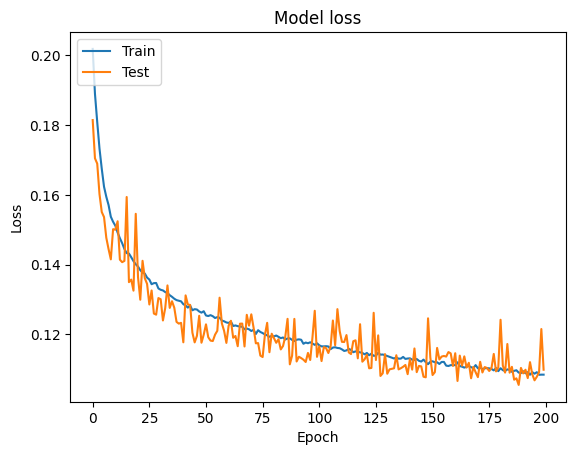

1507/1507 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Final test r2 score with loaded model == 0.7366615209001872


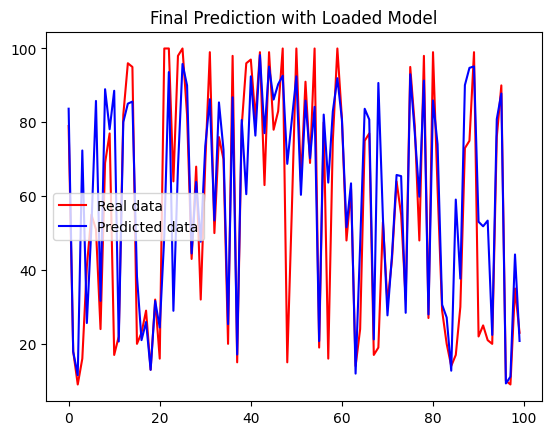

MLP training complete. Model and results saved.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from keras.callbacks import Callback
import plotly.express as px
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import scipy.stats as stats
import pylab as pl

# Load generated data from VAE module
y = np.load(r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated-data-true-window2.npy')
x = np.load(r'/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated-data2.npy')
x = x.reshape(x.shape[0], -1)
print(f"Loaded data shapes - X: {x.shape}, Y: {y.shape}")

# Distribution visualization
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Distribution before Transformation", fontsize=15)
sns.histplot(y, kde=True, color="red")
plt.show()

# Optional: Remove outliers (commented out as per original code)
# from sklearn.ensemble import IsolationForest
# iso = IsolationForest(contamination=0.4)
# yhat = iso.fit_predict(x)
# mask = yhat != -1
# x, y = x[mask, :], y[mask]

# Scale the target and split data
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
y_transformed = transformer.fit_transform(y.reshape(-1, 1)).flatten()
x_train, x_test, y_train, y_test = train_test_split(x, y_transformed, test_size=0.1, random_state=42)

print(f"Train/Test split - X_train: {x_train.shape}, X_test: {x_test.shape}")
print(f"Train/Test split - y_train: {y_train.shape}, y_test: {y_test.shape}")

# Set up model checkpointing
checkpoint_path = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/large/ckp2.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='loss',
    save_best_only=True,
    save_weights_only=True
)

# Build MLP model
from keras.layers import LeakyReLU,Dropout

model = Sequential([
    Dense(64, input_shape=(x_train.shape[1],)),
    LeakyReLU(0.1),
    Dropout(0.1),

    Dense(32),
    LeakyReLU(0.1),
    #Dropout(0.1),

    Dense(16),
    LeakyReLU(0.1),

    Dense(8),
    LeakyReLU(0.1),

    Dense(1)  # linear output
])

optimizr = keras.optimizers.Adam(learning_rate=0.0003, clipnorm=1)
model.compile( loss=tf.keras.losses.Huber(), optimizer=optimizr, metrics=['mae'])

# Check if checkpoint exists and load it
# Check if checkpoint exists and load it
if os.path.exists(checkpoint_path):
    print("Found existing checkpoint. Loading best weights...")

    # Build model with dummy forward pass
    model(x_train[:1])

    # Load the best weights
    model.load_weights(checkpoint_path)
    print("Loaded existing checkpoint weights.")

else:
    print("No existing checkpoint found. Training from scratch...")

    # Build model first
    model(x_train[:1])

    # Now train fully (checkpoint will save best)
    model.fit(
        x_train, y_train,
        epochs=1,
        batch_size=64,
        validation_split=0.1
    )

# Set up callbacks
es = keras.callbacks.EarlyStopping(
    patience=20,
    verbose=1,
    min_delta=0.0001,
    monitor='loss',
    mode='min',
    restore_best_weights=True
)
n_epochs = 200

# Train the model
history = model.fit(x_train, y_train,
                   epochs=n_epochs,
                   batch_size=64,
                   validation_split=0.1,
                   callbacks=[cp_callback,es])

# Plot training history
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Training evaluation
y_train_pred_raw = model.predict(x_train)
y_train_pred = transformer.inverse_transform(y_train_pred_raw)
y_train_true = transformer.inverse_transform(y_train.reshape(-1, 1)).flatten()

score_train = r2_score(y_train_true, y_train_pred)
print("Training r2 score is ==", score_train)

plt.plot(y_train_true[0:100], color='red', label='Real data')
plt.plot(y_train_pred[0:100], color='blue', label='Predicted data')
plt.title('Training Prediction')
plt.legend()
plt.show()

# Test evaluation
y_pred_raw = model.predict(x_test)
y_test_pred = transformer.inverse_transform(y_pred_raw)
y_test_true = transformer.inverse_transform(y_test.reshape(-1, 1)).flatten()

score = r2_score(y_test_true, y_test_pred)
print("Test r2 score is ==", score)

plt.plot(y_test_true[100:200], color='red', label='Real data')
plt.plot(y_test_pred[100:200], color='blue', label='Predicted data')
plt.title('Test Prediction')
plt.legend()
plt.show()

# Save model and results

model.save(r'/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_10Sec.keras')
# Final training history plot
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Load and test saved model
base_model = keras.models.load_model(r'/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_10Sec.keras')

# Final test evaluation with loaded model
y_pred_raw = base_model.predict(x_test)
y_test_pred = transformer.inverse_transform(y_pred_raw)
y_test_true = transformer.inverse_transform(y_test.reshape(-1, 1)).flatten()

score = r2_score(y_test_true, y_test_pred)
print("Final test r2 score with loaded model ==", score)

plt.plot(y_test_true[100:200], color='red', label='Real data')
plt.plot(y_test_pred[100:200], color='blue', label='Predicted data')
plt.title('Final Prediction with Loaded Model')
plt.legend()
plt.show()

# Save results
np.savetxt(r'/content/drive/MyDrive/PHD/2025/MLPOutput/METROPM_predicted_window_10Sec.csv', y_test_pred)
np.savetxt(r'/content/drive/MyDrive/PHD/2025/MLPOutput/METROPM_derived_window_label_10Sec.csv', y_test_true)
np.savetxt(r'/content/drive/MyDrive/PHD/2025/MLPOutput/METROPM_test_data.csv_10Sec', x_test)

print("MLP training complete. Model and results saved.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')